In [54]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import pandas as pd

from random import randint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

In [55]:
class SampleData:
    def get_moon(self, n_samples, noise=0.05):
        noisy_moons = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=42)
        return noisy_moons[0], noisy_moons[1]

    def get_donut(self, n_samples, noise=0.05, factor=0.5):
        noisy_circles = datasets.make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=2)
        return noisy_circles[0], noisy_circles[1]

    def plot(self, X, y):
        ax = plt.gca()
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.show()

In [56]:
class SVM():
    def __init__(self, iterations=500, lam =1):
        self.w = None
        self.support_vectors = []
        self.iterations = iterations
        self.lam = lam
        self.loss = []

    def fit(self, x, y):
        shape = x[0].shape
        weights = np.zeros(shape)
        num_S = x.shape[0]
        self.loss =[]

        for i in range(self.iterations):
            it = randint(0, num_S-1)
            step = 1/(self.lam*(i+1))
            decision = y[it] * np.dot(weights,x[it])    
            if decision < 1:
                weights = (1 - (step*self.lam)) * weights + step*y[it]*x[it]
            else:
                weights = (1 - (step*self.lam)) * weights
            #weights = min(1, (1/math.sqrt(self.lam))/(np.linalg.norm(weights)))*weights
            loss = (1 / 2) * (np.linalg.norm(weights) ** 2) * self.lam + (np.sum(np.maximum(0, 1 - decision))/shape)
            self.loss.append(loss)

        self.w = weights
        self.support_vectors = np.where(self.desicion_function(x)*y <= 1)[0]
        print(self.support_vectors)

    def desicion_function(self,x):
        size = x.shape[0]
        results = np.zeros(size)
        for i in range(size): 
            decision = np.dot(self.w, x[i].T)
            results[i] = decision    
        return results

    def predict(self, x, raw=False):
        results = self.desicion_function(x)
        results = list(map(lambda x: 1 if x >= 0 else -1 ,results))
        return results

In [57]:

class SGDSVC(object):
    def __init__(self,
                 kernel="rbf", lmd=1e-1, gamma=1, bias=1.0, max_iter=500):
        if kernel not in self.__kernel_dict:
            print(kernel + " kernel does not exist!\nUse rbf kernel.")
            kernel = "rbf"
        if kernel == "rbf":
            def kernel_func(x, y):
                return self.__kernel_dict[kernel](x, y, gamma=gamma)
        else:
            kernel_func = self.__kernel_dict[kernel]
        self.kernel = kernel_func
        self.lmd = lmd
        self.bias = bias
        self.max_iter = max_iter

    def __linear_kernel(x, y):
        return np.dot(x, y)

    def __get_alfavalues(self):
        alpha = self.alpha
        #print("get alfa values function")
        #print(alpha)
        length = [x[0] for x in [i for i in alpha]]
        return(np.count_nonzero(length))

    def __gaussian_kernel(x, y, gamma):
        #print("x:"+str(np.shape(x)))
        #print("y:"+str(np.shape(y)))
        diff = x - y
        return np.exp(-gamma * np.dot(diff, diff))

    __kernel_dict = {"linear": __linear_kernel, "rbf": __gaussian_kernel}

    def fit(self, X, y):
        def update_alpha(alpha, t):
            data_size, feature_size = np.shape(self.X_with_bias)
            new_alpha = np.copy(alpha)
            it = np.random.randint(low=0, high=data_size)
            x_it = self.X_with_bias[it]
            y_it = self.y[it]
            if (y_it *
                (1. / (self.lmd * t)) *
                sum([alpha_j * y_j * self.kernel(x_it, x_j)
                     for x_j, y_j, alpha_j in zip(self.X_with_bias, y, alpha)])) < 1.:
                new_alpha[it] += 1
            return new_alpha

        print(str(np.shape(X)))
        self.X_with_bias = np.c_[X, np.ones((np.shape(X)[0])) * self.bias]
        self.y = y
        alpha = np.zeros((np.shape(self.X_with_bias)[0], 1))
        for t in range(1, self.max_iter + 1):
            alpha = update_alpha(alpha, t)

        #print(alpha)
        #print(self.alpha)
        self.alpha = alpha

    def decision_function(self, X):
        print(str(np.shape(X)))
        X_with_bias = np.c_[X, np.ones((np.shape(X)[0])) * self.bias]
        y_score = [(1. / (self.lmd * self.max_iter)) *
                   sum([alpha_j * y_j * self.kernel(x_j, x)
                        for (x_j, y_j, alpha_j) in zip(
                        self.X_with_bias, self.y, self.alpha)])
                   for x in X_with_bias]
        return np.array(y_score)

    def predict(self, X):
        y_score = self.decision_function(X)
        y_predict = map(lambda s: 1 if s >= 0. else -1, y_score)
        return y_predict

In [58]:
class SVMK():
    def __init__(self, iterations=500, lam=1, kernel="rbf", gamma=1):
        self.w = None
        self.x = None
        self.y = None
        self.support_vectors = []
        self.gamma = gamma
        self.iterations = iterations
        self.lam = lam

        if kernel == "rbf":
            self.kernel = self.rbf_kernel
        else:
            self.kernel = self.polynomial_kernel
            self.degree = 2

    def fit(self, x, y):
        x_bias = np.c_[x, np.ones(x.shape[0])]

        num_S =  x_bias.shape[0]
        alpha = np.zeros((num_S, 1))

        for i in range(self.iterations):
            it = np.random.randint(low=0, high=num_S)
            x_it = x_bias[it]

            step =  1 / (self.lam * i+1)
            result = (y[it] * step * sum([alpha_j * y_j * self.kernel(x_it, x_j)
                     for (x_j, y_j, alpha_j) in zip(x_bias, y, alpha)]))[0]

            if result < 1:
                 alpha[it] += 1
        
        self.alpha = alpha
        self.x = np.copy(x_bias)
        self.y = np.copy(y)
        self.support_vectors = np.where(self.desicion_function(x)*y <= 1)[0]

    def rbf_kernel(self, x, y):
        mean = np.linalg.norm(x - y)**2
        return np.exp(-mean/(2*(self.gamma**2)))

    def polynomial_kernel(self, x, y):
        return (1+x.dot(y.T)) ** self.degree
  
    def desicion_function(self, x): 
        x_bias = np.c_[x, np.ones(x.shape[0])]
        step = 1
        y = [(step * sum([alpha_j * y_j * self.kernel(x_j, x)
                        for (x_j, y_j, alpha_j) in zip(
                        self.x, self.y, self.alpha)]))[0]
                   for x in x_bias]
        return y

    def predict(self, x):
        y = self.desicion_function(x)
        y = list(map(lambda x: 1 if x >= 0 else -1 ,y))
        return np.array(y)

In [59]:
def random(n):
    X1 = []
    X2 = []
    y = []

    for i in range(n//2):
        X1.append(np.random.randint(50))
        X2.append(np.random.randint(300,350))
        y.append(-1)

    for i in range(n//2):
        X1.append(np.random.randint(50))
        X2.append(np.random.randint(400,450))
        y.append(1)

    return X1,X2,y

def standardize(data):
    data -= np.mean(data)
    data /= np.std(data)
    return data

def plot(X, Y, support_vectors):
    colors = np.array([ 'g', 'm', 'c' ])
    plt.scatter(X[:,0],X[:,1],c=colors[Y])
    plt.scatter(X[:, 0][support_vectors], X[:, 1][support_vectors], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
    plt.xlabel('X1',fontweight="bold",fontsize = 15)
    plt.ylabel('X2',fontweight="bold",fontsize = 15)
    plt.title("Scatter Data",fontweight="bold",fontsize = 20)
    plt.show()

[ 0  4 18 23 26 32 36 41 45 50 53 54 55 63 72 73 78 84 94 95 98]


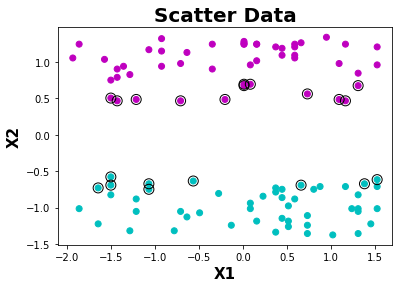

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

-------------------------------------------------------
Confusion Matrix

[[50  0]
 [ 0 50]]


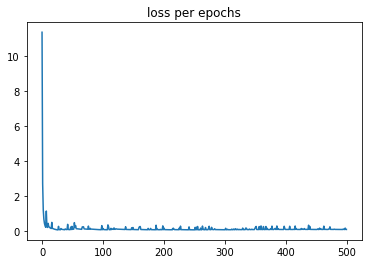

In [60]:
X1,X2,y = random(100)

X1 = (X1 - np.mean(X1))/ np.std(X1)
X2 = standardize(X2)

X = np.array(list(zip(X1,X2)))
Y = np.array(y)


model = SVM(lam=0.1)
model.fit(X,Y)

Y_predict = model.predict(X)

plot(X,Y,model.support_vectors)
print(classification_report(Y, Y_predict))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y, Y_predict))

plt.plot(model.loss)
plt.title("loss per epochs")
plt.show()


In [61]:
model = svm.LinearSVC()
model.fit(X,Y)

Y_predict = model.predict(X)

decision_function = model.decision_function(X)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]

print(support_vector_indices)
print(classification_report(Y, Y_predict))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y, Y_predict))

[ 0  4 23 26 32 41 45 53 54 55 73 84 95 98]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

-------------------------------------------------------
Confusion Matrix

[[50  0]
 [ 0 50]]


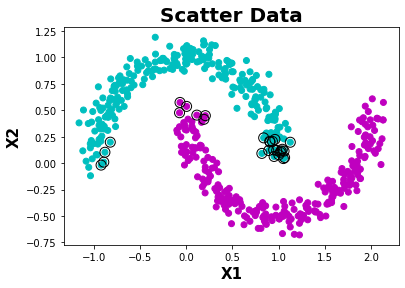

              precision    recall  f1-score   support

          -1       1.00      0.98      0.99       250
           1       0.98      1.00      0.99       250

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500

-------------------------------------------------------
Confusion Matrix

[[246   4]
 [  0 250]]


In [73]:
sample = SampleData()
X, Y = sample.get_moon(n_samples=500, noise=0.08)
Y[Y == 0] = -1

model = SVMK(lam=1e-3, gamma=1)
model.fit(X,Y)

Y_predict = model.predict(X)

plot(X,Y,model.support_vectors)
print(classification_report(Y, Y_predict))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y, Y_predict))


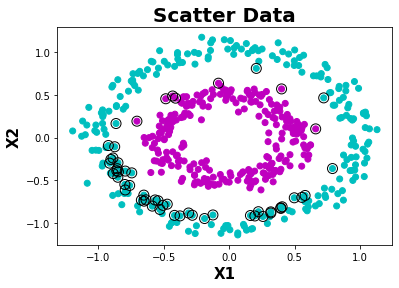

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       250

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

-------------------------------------------------------
Confusion Matrix

[[249   1]
 [  0 250]]


In [63]:
sample = SampleData()
X, Y = sample.get_donut(n_samples=500, noise=0.08)
Y[Y == 0] = -1

model = SVMK(lam=1e-5, gamma=1)
model.fit(X,Y)

Y_predict = model.predict(X)

plot(X,Y,model.support_vectors)
print(classification_report(Y, Y_predict))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y, Y_predict))


In [64]:
df = datasets.load_breast_cancer()
X, X_test, Y, Y_test = train_test_split(df.data, df.target, test_size=0.3,random_state=109) 

function = lambda x: 1 if x == 1 else -1
vfunc = np.vectorize(function)

Y = vfunc(Y)
Y_test = vfunc(Y_test)


In [65]:
model = SVMK(lam=1e-5, iterations=2000, gamma=5)
model.fit(X,Y)

Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y_test, Y_pred))

              precision    recall  f1-score   support

          -1       0.92      0.90      0.91        63
           1       0.94      0.95      0.95       108

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

-------------------------------------------------------
Confusion Matrix

[[ 57   6]
 [  5 103]]


In [66]:
model = svm.SVC(kernel='rbf')
model.fit(X,Y)
Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y_test, Y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.79      0.88        63
           1       0.89      1.00      0.94       108

    accuracy                           0.92       171
   macro avg       0.95      0.90      0.91       171
weighted avg       0.93      0.92      0.92       171

-------------------------------------------------------
Confusion Matrix

[[ 50  13]
 [  0 108]]


In [67]:
df = pd.read_csv('diabetes.csv')
df["Outcome"] = df["Outcome"].map({0:-1, 1:1})
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,-1
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,-1
4,0,137,40,35,168,43.1,2.288,33,1


In [68]:
train, test = train_test_split(df, test_size=0.3,random_state=109) 

X = train.iloc[:,:-1].to_numpy()
Y = train.iloc[:,-1:].to_numpy()
Y = np.squeeze(np.asarray(Y))

X_test = test.iloc[:,:-1].to_numpy()
Y_test = test.iloc[:,-1:].to_numpy()
Y_test = np.squeeze(np.asarray(Y_test))

In [69]:
model = SVMK(lam=1e-1, iterations=2000, gamma=25)
model.fit(X,Y)

Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y_test, Y_pred))

              precision    recall  f1-score   support

          -1       0.72      0.94      0.81       149
           1       0.75      0.33      0.46        82

    accuracy                           0.72       231
   macro avg       0.73      0.63      0.64       231
weighted avg       0.73      0.72      0.69       231

-------------------------------------------------------
Confusion Matrix

[[140   9]
 [ 55  27]]


In [70]:
model = svm.SVC(kernel='rbf')
model.fit(X,Y)
Y_pred = model.predict(X_test)

print(classification_report(Y_test, Y_pred))
print('-'*55)
print('Confusion Matrix\n')
print(confusion_matrix(Y_test, Y_pred))

              precision    recall  f1-score   support

          -1       0.76      0.93      0.83       149
           1       0.78      0.46      0.58        82

    accuracy                           0.76       231
   macro avg       0.77      0.69      0.71       231
weighted avg       0.76      0.76      0.74       231

-------------------------------------------------------
Confusion Matrix

[[138  11]
 [ 44  38]]
